In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import os
from matplotlib import pyplot as plot
from random import randint
import time

In [2]:
def calculate_mean_std(data):
    data = cifar_trainset.data / 255
    mean = data.mean(axis=(0, 1, 2))
    std = data.std(axis=(0, 1, 2))
    return mean, std

In [3]:
def create_dataset(root, train, transform=None):
    return torchvision.datasets.CIFAR10(root=root, train=train, download=True, transform=transform)

In [4]:
root = './dataset'
batch_size = 128
epochs = 25
learning_rate = 0.001

In [5]:
cifar_trainset = create_dataset(root, train=True)
mean, std = calculate_mean_std(cifar_trainset.data)

Files already downloaded and verified


In [6]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

In [7]:
train_dataset = create_dataset(root, train=True, transform=transform_train)
test_dataset = create_dataset(root, train=False, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(f'Classes of dataset: {class_names}')


Classes of dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
def denormal(image, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return image * stds + means
def show_images(images, title):
    num_showed_imgs_x = 5
    num_showed_imgs_y = 5
    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize=figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks=[], yticks=[])
    for i, ax in enumerate(axes.flat):
        means, stds = calculate_mean_std(images)
        img = images[i][0]
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow((img * 255).astype('uint8'))
        ax.set_title(train_dataset.classes[images[i][1]])

In [10]:
print('Number of train samples: {}'.format(len(train_dataset)))
print('Number of test samples: {}'.format(len(test_dataset)))

Number of train samples: 50000
Number of test samples: 10000


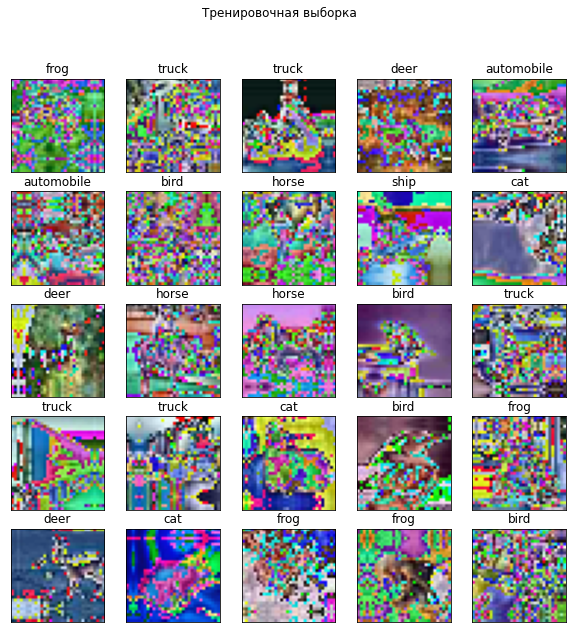

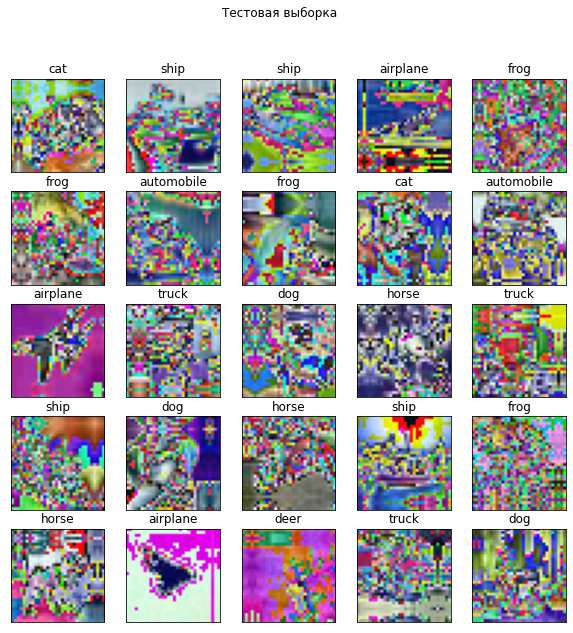

In [11]:
show_images(train_dataset, 'Тренировочная выборка')
show_images(test_dataset, 'Тестовая выборка')

In [12]:
class ResNet10(torch.nn.Module):
    def __init__(self):
        super(ResNet10, self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(3, 64, kernel_size=3, padding=1),
                                         torch.nn.BatchNorm2d(64),
                                         torch.nn.ReLU(inplace=True))
        self.conv_and_pool_1 = torch.nn.Sequential(torch.nn.Sequential(torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                                                       torch.nn.BatchNorm2d(128),
                                                                       torch.nn.ReLU(inplace=True)), torch.nn.MaxPool2d(kernel_size=2))
        self.res1 = torch.nn.Sequential(torch.nn.Sequential(torch.nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                                            torch.nn.BatchNorm2d(128), torch.nn.ReLU(inplace=True)),torch.nn.Sequential(torch.nn.Conv2d(128, 128, kernel_size=3, padding=1), torch.nn.BatchNorm2d(128), torch.nn.ReLU(inplace=True)))
        self.conv_and_pool_2 = torch.nn.Sequential(torch.nn.Sequential(torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                                                       torch.nn.BatchNorm2d(256), torch.nn.ReLU(inplace=True)), torch.nn.MaxPool2d(kernel_size=2))
        self.conv_and_pool_3 = torch.nn.Sequential(torch.nn.Sequential(torch.nn.Conv2d(256, 512, kernel_size=3, padding=1),
                                                                       torch.nn.BatchNorm2d(512), torch.nn.ReLU(inplace=True)), torch.nn.MaxPool2d(kernel_size=2))
        self.res2 = torch.nn.Sequential(torch.nn.Sequential(torch.nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                                            torch.nn.BatchNorm2d(512), torch.nn.ReLU(inplace=True)), torch.nn.Sequential(torch.nn.Conv2d(512, 512, kernel_size=3, padding=1), torch.nn.BatchNorm2d(512), torch.nn.ReLU(inplace=True)))
        self.final_pool = torch.nn.MaxPool2d(kernel_size=4)
        self.dense = torch.nn.Sequential(torch.nn.Flatten(),
                                         torch.nn.Dropout(0.2),
                                         torch.nn.Linear(512, 10))

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv_and_pool_1(out)
        out = self.res1(out) + out
        out = self.conv_and_pool_2(out)
        out = self.conv_and_pool_3(out)
        out = self.res2(out) + out
        out = self.final_pool(out)
        out = self.dense(out)
        return out

In [13]:
cnn_model = ResNet10()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

ResNet10(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_and_pool_1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [14]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
train_dataset.transform = transform_train
test_dataset.transform = transform_test
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
print('Training parameters: learning rate = {}, batch size = {}, number of epochs = {}'.format(learning_rate, batch_size, epochs))

Training parameters: learning rate = 0.001, batch size = 128, number of epochs = 25


In [16]:
def train(Network):
    for epoch in range(epochs):
        start = time.time()
        losses = []
        for i, (images, labels) in enumerate(train_data_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = Network(images)
            loss = loss_function(outputs, labels)
            losses.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        duration = time.time() - start
        print('Epoch[{}]: loss = {}, accuracy = {}, time = {}'.format(epoch, torch.stack(losses).mean(), get_accuracy(Network, train_data_loader, device), duration))
    print('Test accuracy: {}'.format(get_accuracy(cnn_model, test_data_loader, device)))

In [17]:
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

In [18]:
def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

In [20]:
loss = get_loss(cnn_model, test_data_loader, device)
accuracy = get_accuracy(cnn_model, test_data_loader, device)
print(f'Loss = {loss}, accuracy = {accuracy}')

Loss = 0.02519952319562435, accuracy = 0.10029999911785126


In [21]:
train(cnn_model)

Epoch[0]: loss = 1.368216872215271, accuracy = 0.6708400249481201, time = 508.179945230484
Epoch[1]: loss = 0.8440895080566406, accuracy = 0.7351800203323364, time = 529.3635017871857
Epoch[2]: loss = 0.6773177981376648, accuracy = 0.7701200246810913, time = 519.5207695960999
Epoch[3]: loss = 0.5745354890823364, accuracy = 0.8249599933624268, time = 534.0239078998566
Epoch[4]: loss = 0.49700069427490234, accuracy = 0.8348199725151062, time = 549.6380326747894
Epoch[5]: loss = 0.44929036498069763, accuracy = 0.8607199788093567, time = 701.3564352989197
Epoch[6]: loss = 0.4101394712924957, accuracy = 0.8799600005149841, time = 696.584180355072
Epoch[7]: loss = 0.3654502332210541, accuracy = 0.8858000040054321, time = 625.5004458427429
Epoch[8]: loss = 0.3342764675617218, accuracy = 0.894540011882782, time = 505.70746755599976
Epoch[9]: loss = 0.30710551142692566, accuracy = 0.9117199778556824, time = 543.7355909347534
Epoch[10]: loss = 0.28874948620796204, accuracy = 0.9114999771118164, 